In [14]:
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout
from keras import optimizers, regularizers
from datetime import datetime
from keras.callbacks import ModelCheckpoint, TensorBoard
import numpy as np
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import csv
np.random.seed(7)

### Define parameters

In [19]:
no_of_layers = 10 # number of hidden layers except input and output layer
input_layer = 7
output_layer = 1
no_of_neurons = 50

# create layer information
layer = [input_layer]
for i in range(no_of_layers):
    layer.append(no_of_neurons)
layer.append(output_layer)

learning_rate = 0.0001
training_epochs = 50
batch_size = 100
keep_prob = 1.0
no_of_data = 5000

### Get Data
1. Coloumn 0 : Temperature 
2. Coloumn 1 : Density
3. Coloumn 2 : P-wave velocity(V_p)    
4. Coloumn 3 : S- wave velocity (V_s)
5. Coloumn 4 : Ratio of V_p and V_s
6. Coloumn 5 : Thermal Energy 
7. Coloumn 6 : Depth(z)
8. Coloumn 7 : x coordinate
9. Coloumn 8 : Stress component xx
10. Coloumn 9 : Stress component xz
11. Coloumn 10 : Stress component zz
    
The data file has no any header and has 11 columns. The X can be first seven columns. We do not need x coordinate (8 column). This column can be ignored. Based on X we want to predict any of the stress components (xx/xz/zz).

In [20]:
def get_stress_data():
    filename = "data/stress_data.csv"
#     data = pd.read_csv(data_path)
#     data = data.values
#     data = data[0:no_of_data, :]

    
    raw_data = open(filename, 'rt')
    reader = csv.reader(raw_data, delimiter=',', quoting=csv.QUOTE_NONE)
    data = list(reader)
    data = np.array(data).astype('float')
    X = data[:no_of_data, : input_layer] # [it looks like it is 1 indexed]
    Y = data[:no_of_data, 9] # shear stress [it looks like it is 0 indexed]
    
    return X, Y

# get_stress_data(1000)

In [21]:
X, Y = get_stress_data()
X, Y = shuffle(X, Y, random_state=0)
X = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True).fit_transform(X)
Y = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True).fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
total_len_train = X_train.shape[0]
total_len_test = X_test.shape[0]

/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [22]:
print(X_train.shape)
print(X_test.shape)
print(X_train[:5, :])

(3500, 7)
(1500, 7)
[[  7.82044066e-06   8.78582517e-01   1.21320014e-01   1.21320016e-01
    0.00000000e+00   7.82362665e-06   6.33659908e-03]
 [  2.59457674e-06   7.56963934e-01   2.42867955e-01   2.42867956e-01
    0.00000000e+00   2.59558869e-06   2.63606046e-01]
 [  3.62016327e-02   8.64542216e-01   1.35350781e-01   1.35350781e-01
    0.00000000e+00   3.62160737e-02   8.92265996e-01]
 [  2.07649654e-01   6.11780691e-01   3.88002246e-01   3.88002244e-01
    0.00000000e+00   2.07668525e-01   6.91760990e-01]
 [  2.42593384e-04   2.99327849e-01   7.00480412e-01   7.00480413e-01
    0.00000000e+00   2.42524821e-04   4.05261942e-01]]


### Model setup

In [23]:
# Multilayer Perceptron model
model = Sequential()
length = len(layer)-1
for i in range(length):    
    if (i < length-1):
        model.add(Dense(units=layer[i+1], input_dim=layer[i],
                use_bias=True,
                kernel_initializer='truncated_normal',
                bias_initializer='truncated_normal',
                activation='relu', 
                name='layer_'+str(i+1)))
        
        if (keep_prob < 1.0):
            model.add(Dropout(keep_prob, name='dropout_'+str(i+1)))
    
    # output layer
    else:
        model.add(Dense(units=layer[i+1], input_dim=layer[i], name='output'))

opt = optimizers.Adam(lr=learning_rate)
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['accuracy'])
#model.summary()

### Training

In [10]:
# Training
now = datetime.now()
path = './graph/' + 'stress'+ now.strftime("%Y%m%d-%H%M")+'_drop_' +\
        str(keep_prob)+'_layer_'+ str(no_of_layers) +'_data_'+ str(no_of_data) +\
        '_neuron_' + str(no_of_neurons)

print(path)
save_model(model, './logs/stress')
checkpoint = ModelCheckpoint(filepath='./logs/stress_weights.epoch.{epoch:02d}.hdf5', verbose=0)
tbCallBack = TensorBoard(log_dir=path, histogram_freq=1, write_graph=True)

history = model.fit(X_train, Y_train, epochs = training_epochs, batch_size=batch_size, verbose=1, 
                    callbacks=[checkpoint, tbCallBack], validation_data=(X_test, Y_test))

./graph/stress20170606-1128_drop_1.0_layer_1_data_5000_neuron_2
Train on 3500 samples, validate on 1500 samples
INFO:tensorflow:Summary name layer_1/kernel:0 is illegal; using layer_1/kernel_0 instead.
INFO:tensorflow:Summary name layer_1/bias:0 is illegal; using layer_1/bias_0 instead.
INFO:tensorflow:Summary name output/kernel:0 is illegal; using output/kernel_0 instead.
INFO:tensorflow:Summary name output/bias:0 is illegal; using output/bias_0 instead.
Epoch 1/50
3500/3500 [==============================] - 0s - loss: 0.0668 - acc: 2.8571e-04 - val_loss: 0.0062 - val_acc: 0.0000e+00
Epoch 2/50
3500/3500 [==============================] - 0s - loss: 0.0019 - acc: 2.8571e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 3/50
3500/3500 [==============================] - 0s - loss: 0.0015 - acc: 2.8571e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 4/50
3500/3500 [==============================] - 0s - loss: 0.0015 - acc: 2.8571e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 5/

KeyboardInterrupt: 

## Plot loss and accuracy 

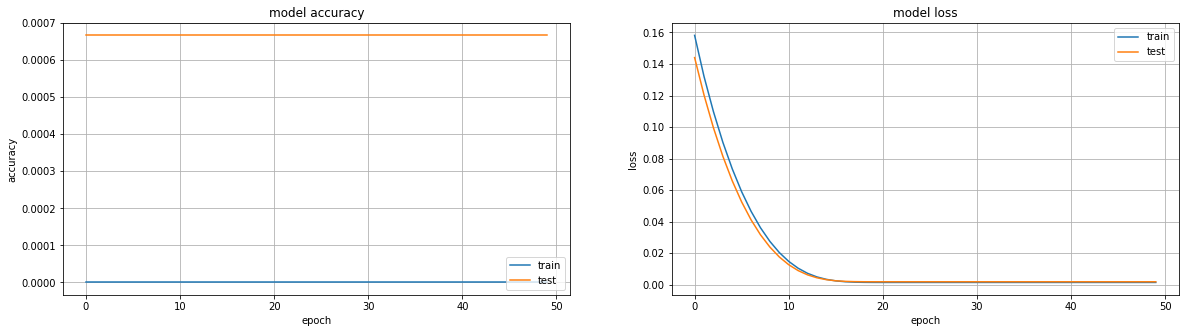

In [7]:
#print(history.history.keys())

plt.figure(figsize=(20,5))
# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.grid()
# plt.show()

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid()
plt.show()

## Make prediction and visualize the prediction

In [8]:
# Restore trained model
loaded_model = load_model('./logs/stress')
loaded_model.load_weights('./logs/stress_weights.epoch.49.hdf5')
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
output (Dense)               (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


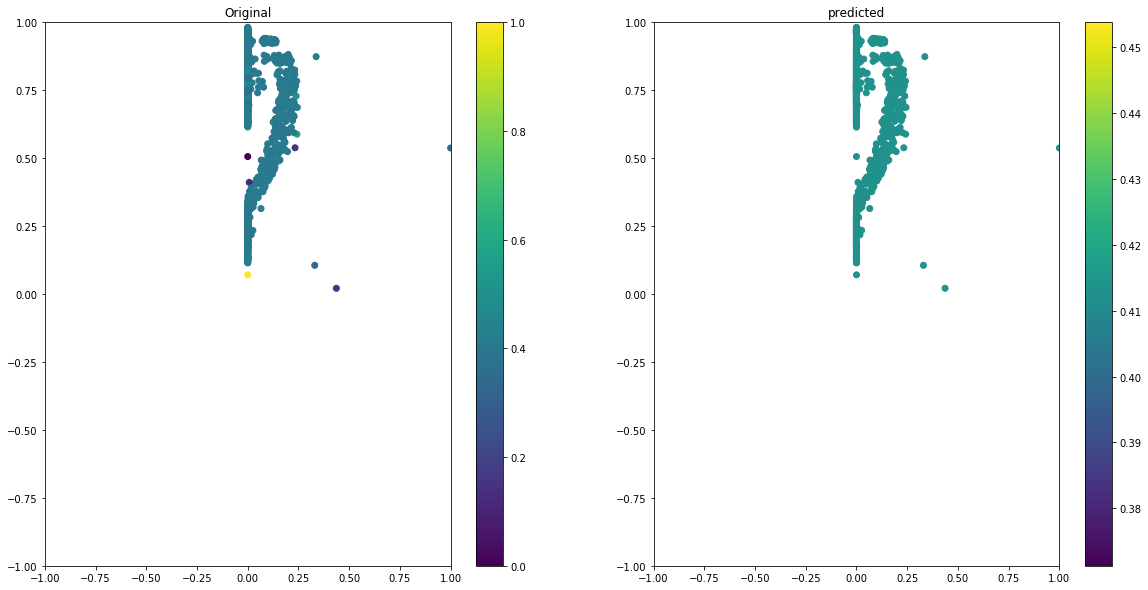

In [9]:
predicted = loaded_model.predict(X_test)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(X_test[:,0], X_test[:, 1], c=Y_test)
plt.title("Original")
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(X_test[:,0], X_test[:, 1], c=predicted)
plt.title("predicted")
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.colorbar()

plt.show()

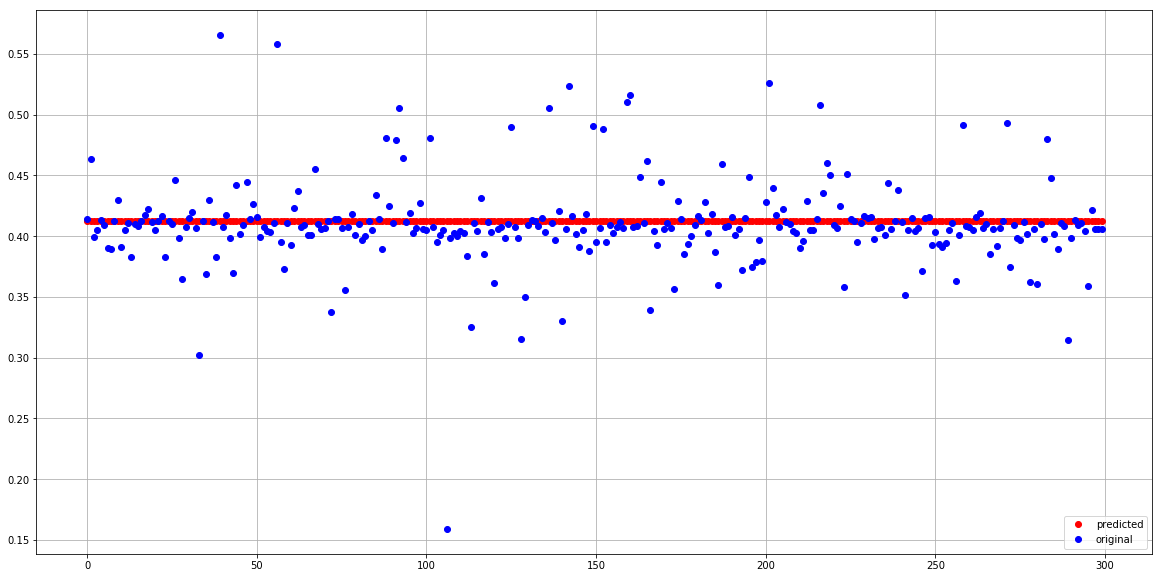

In [10]:
data = 300
plt.figure(figsize=(20,10))
plt.plot(predicted[:data], 'ro')
plt.plot(Y_test[:data], 'bo')
plt.legend(['predicted', 'original'], loc='lower right')
plt.grid()
plt.show()

## Restore model

In [11]:
# Evaluate with loaded model
evaluation = loaded_model.evaluate(X_test, Y_test, batch_size=10, verbose=1)
print('\nSummary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

1340/1500 [=========================>....] - ETA: 0s
Summary: Loss over the test dataset: 0.00, Accuracy: 0.00


## playinmg with the model

In [13]:
# "get_config()" returns a dictionary containing the configuration of the layer
# loaded_model.get_config()
# loaded_model.to_json()

#returns a list of all weight tensors in the model, as Numpy arrays
a = loaded_model.get_weights()
print(a) # 10 layers
# print(a[2])

[array([[-0.0459014 , -0.01663   ],
       [ 0.00545557, -0.07344743]], dtype=float32), array([-0.00600419, -0.04444616], dtype=float32), array([[-0.46745339],
       [-0.7701261 ]], dtype=float32), array([ 0.41252333], dtype=float32)]


## Create image from weights

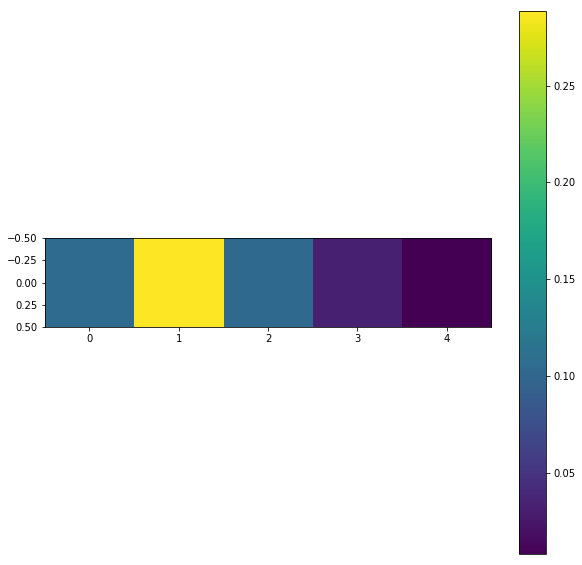

In [14]:
image = np.square(a[2].T)
plt.figure(figsize=(10,10))
plt.imshow(image, cmap=plt.cm.viridis, interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
# from skimage import io, filters
# image = io.imread('download.jpg')
# # edges = filters.sobel(image)
# io.imshow(image)
# io.show()